Collaborative Filtering via Matrix Factorization. Future comparisons between efficacy and time complexity when integrating differential privacy

In [1]:
import os
import numpy as np
import pandas as pd
from diffprivlib.mechanisms import Laplace
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

#device = torch.device('cpu')
#print(torch.cuda.current_device())

Using device: cuda
Device Name: NVIDIA GeForce RTX 3070 Laptop GPU


In [2]:
#ratings_df = pd.read_csv("ml-32m/ratings.csv")
#print(ratings_df.head())

#movies_df = pd.read_csv("ml-32m/movies.csv")
#print(movies_df.head())

movies_df = pd.read_csv("ml-1m/movies.dat", sep="::", header=None, engine='python', encoding='ISO-8859-1')
movies_df.columns = ['movieId', 'title', 'genres']

'''
links_df = pd.read_csv("ml-32m/links.csv")
#print(links_df.head())

tags_df = pd.read_csv("ml-32m/tags.csv")
#print(tags_df.head())

def preprocessing(df):
    num_reviews_per_user = df.groupby("userId").size() # Number of reviews a certain user has
    result = num_reviews_per_user[num_reviews_per_user >= 15].index # More than 15 reviews
    modified_df = df[df["userId"].isin(result)].copy()
    return modified_df

ratings_df = preprocessing(ratings_df)
print(ratings_df.head())
'''
class NCF_Data(object):
	def __init__(self, ratings):
		self.ratings = ratings
		self.num_ng = 4
		self.num_ng_test = 99
		self.batch_size = 1024

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)
		random.seed(1224401633)
	
	def _reindex(self, ratings):
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]
	

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(list(x), self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self, device):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(list(x), self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Dataset(
			user_list=users,
			item_list=items,
			rating_list=ratings,
			device=device)
		return torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0)

	def get_test_instance(self, device):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Dataset(
			user_list=users,
			item_list=items,
			rating_list=ratings,
			device=device)
		return torch.utils.data.DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=0)

class Rating_Dataset(torch.utils.data.Dataset):
    def __init__(self, user_list, item_list, rating_list, device):
        super(Rating_Dataset, self).__init__()
        self.user_list = torch.tensor(user_list, dtype=torch.int64, device=device)
        self.item_list = torch.tensor(item_list, dtype=torch.int64, device=device)
        self.rating_list = torch.tensor(rating_list, dtype=torch.float32, device=device)

    def __len__(self):
        return len(self.user_list)

    def __getitem__(self, idx):
        return self.user_list[idx], self.item_list[idx], self.rating_list[idx]


def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

In [ ]:
## Generalized Matrix Factorization Architecture
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, factor_num=10):
        super(MatrixFactorization, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = factor_num # Needs ot change factor num
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)
        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        output = torch.sigmoid(self.output_layer(element_product))
        return output

class NeuMF(nn.Module):
    def __init__(self, config, num_users, num_items):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num_mf = config['factor_num']
        self.factor_num_mlp =  int(config['layers'][0]/2)
        self.layers = config['layers']
        self.dropout = config['dropout']

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mlp)

        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mf)
        #self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=32)
        #self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=32)

        #self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=32)
        #self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=32)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())

        self.affine_output = nn.Linear(in_features=config['layers'][-1] + self.factor_num_mf, out_features=1)
        self.logistic = nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        nn.init.normal_(self.embedding_user_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_user_mf.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mf.weight, std=0.01)
        
        for m in self.fc_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                
        nn.init.xavier_uniform_(self.affine_output.weight)

        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

#ratings = pd.read_csv("ml-32m/ratings.csv")
#ratings = pd.read_csv("ml-latest-small/ratings.csv")
#ratings.rename(columns={"userId": "user_id", "movieId": "item_id"}, inplace=True)

ratings = pd.read_csv("ml-1m/ratings.dat", sep="::", header=None, engine='python', encoding='ISO-8859-1')
ratings.columns = ["user_id", "item_id", "rating", "timestamp"]

scaler = MinMaxScaler()
ratings['rating'] = scaler.fit_transform(ratings[['rating']])

epsilon = 3.0
laplace_mech = Laplace(epsilon=epsilon, sensitivity=1.0)

#ratings['rating'] = ratings['rating'].apply(laplace_mech.randomise)

num_users = ratings['user_id'].nunique() + 1
num_items = ratings['item_id'].nunique() + 1

ncf_data = NCF_Data(ratings)

train_loader = ncf_data.get_train_instance(device)
test_loader = ncf_data.get_test_instance(device)

config = {
    'num_users': num_users,
    'num_items': num_items,
    'factor_num': 8,
    'latent_dim_mf': 8,
    'latent_dim_mlp': 8,
    'layers': [64, 64, 64, 8],
    'weight_init_gaussian': True,
    'dropout': 0.2,
    'top_k': 10
}
model = NeuMF(config, num_users, num_items).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#train_users = torch.tensor(train_df["userId"].values, dtype=torch.long).to(device)
#train_items = torch.tensor(train_df["movieId"].values, dtype=torch.long).to(device)
#train_ratings = torch.tensor(train_df["rating"].values, dtype=torch.float32).to(device)

In [4]:

n_epochs = 20
best_hr = 0

# To store metrics for plotting
losses = []
hrs = []
ndcgs = []

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    
    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        prediction = model(user, item)
        loss = criterion(prediction, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    model.eval()
    HR, NDCG = metrics(model, test_loader, config['top_k'], device)

    loss_on_epoch = epoch_loss / len(train_loader)
    losses.append(loss_on_epoch)
    hrs.append(np.mean(HR))
    ndcgs.append(np.mean(NDCG))

    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch:03d}: Loss = {loss_on_epoch:.4f}, HR = {np.mean(HR):.3f}, NDCG = {np.mean(NDCG):.3f}")
    print("Elapsed time: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

'''
n_epochs = 50
loss_threshold = 0.1
best_hr = 0
converged = False

losses = []
hrs = []
ndcgs = []

for epoch in range(1, n_epochs + 1):
    if converged:
        break
    
    model.train()
    epoch_loss = 0
    start_time = time.time()  
    for user, item, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        
        dp_ratings = [laplace_mech.randomise(float(r)) for r in rating]

        dp_rating_tensor = torch.tensor(dp_ratings, dtype=torch.float32).to(device)
        dp_rating_tensor = torch.clamp(dp_rating_tensor, min=0.0, max=1.0)
        
        optimizer.zero_grad()
        prediction = model(user, item)
        loss = criterion(prediction, dp_rating_tensor)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    loss_on_epoch = epoch_loss / len(train_loader)
    losses.append(loss_on_epoch)
    
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch}, Loss: {loss_on_epoch:.4f}, Time Elapsed: {elapsed_time:.2f}s")
    
    if loss_on_epoch <= loss_threshold:
        print(f"Convergence achieved at epoch {epoch} with loss {loss_on_epoch:.4f}")
        converged = True

    model.eval()
    HR, NDCG = metrics(model, test_loader, config['top_k'], device)
    print(f"HR: {np.mean(HR):.3f}, NDCG: {np.mean(NDCG):.3f}")
    hrs.append(np.mean(HR))
    ndcgs.append(np.mean(NDCG))
'''

Epoch 001: Loss = 0.3166, HR = 0.564, NDCG = 0.316
Elapsed time: 00:01:52
Epoch 002: Loss = 0.2703, HR = 0.613, NDCG = 0.349
Elapsed time: 00:01:53
Epoch 003: Loss = 0.2557, HR = 0.634, NDCG = 0.368
Elapsed time: 00:01:54
Epoch 004: Loss = 0.2451, HR = 0.649, NDCG = 0.379
Elapsed time: 00:01:48
Epoch 005: Loss = 0.2373, HR = 0.655, NDCG = 0.384
Elapsed time: 00:01:48
Epoch 006: Loss = 0.2311, HR = 0.665, NDCG = 0.388
Elapsed time: 00:01:48
Epoch 007: Loss = 0.2260, HR = 0.658, NDCG = 0.388
Elapsed time: 00:01:49
Epoch 008: Loss = 0.2215, HR = 0.658, NDCG = 0.383
Elapsed time: 00:01:50
Epoch 009: Loss = 0.2174, HR = 0.651, NDCG = 0.383
Elapsed time: 00:01:55
Epoch 010: Loss = 0.2140, HR = 0.651, NDCG = 0.381
Elapsed time: 00:02:08
Epoch 011: Loss = 0.2108, HR = 0.650, NDCG = 0.381
Elapsed time: 00:02:01
Epoch 012: Loss = 0.2081, HR = 0.645, NDCG = 0.376
Elapsed time: 00:01:55
Epoch 013: Loss = 0.2055, HR = 0.651, NDCG = 0.379
Elapsed time: 00:01:56
Epoch 014: Loss = 0.2032, HR = 0.642, 

'\nn_epochs = 50\nloss_threshold = 0.1\nbest_hr = 0\nconverged = False\n\nlosses = []\nhrs = []\nndcgs = []\n\nfor epoch in range(1, n_epochs + 1):\n    if converged:\n        break\n    \n    model.train()\n    epoch_loss = 0\n    start_time = time.time()  \n    for user, item, rating in train_loader:\n        user = user.to(device)\n        item = item.to(device)\n        \n        dp_ratings = [laplace_mech.randomise(float(r)) for r in rating]\n\n        dp_rating_tensor = torch.tensor(dp_ratings, dtype=torch.float32).to(device)\n        dp_rating_tensor = torch.clamp(dp_rating_tensor, min=0.0, max=1.0)\n        \n        optimizer.zero_grad()\n        prediction = model(user, item)\n        loss = criterion(prediction, dp_rating_tensor)\n        loss.backward()\n        optimizer.step()\n        \n        epoch_loss += loss.item()\n    \n    loss_on_epoch = epoch_loss / len(train_loader)\n    losses.append(loss_on_epoch)\n    \n    elapsed_time = time.time() - start_time\n    print

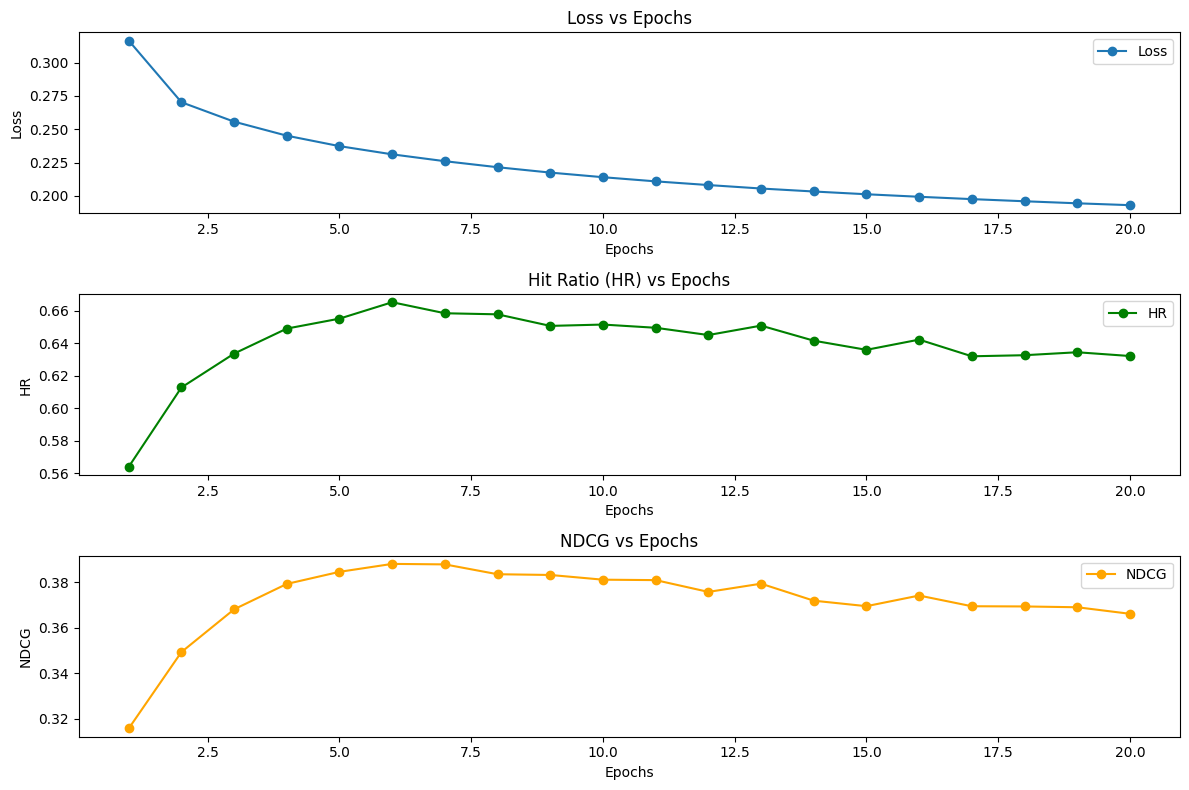

In [5]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(range(1, n_epochs + 1), losses, marker='o', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(1, n_epochs + 1), hrs, marker='o', color='green', label='HR')
plt.xlabel('Epochs')
plt.ylabel('HR')
plt.title('Hit Ratio (HR) vs Epochs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(range(1, n_epochs + 1), ndcgs, marker='o', color='orange', label='NDCG')
plt.xlabel('Epochs')
plt.ylabel('NDCG')
plt.title('NDCG vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
def recommend_movies(model, user_id, all_movie_ids, user_interacted_movies, num_recommendations=10, device=torch.device("cpu")):
    candidate_movie_ids = list(set(all_movie_ids) - user_interacted_movies)
    user_tensor = torch.tensor([user_id] * len(candidate_movie_ids), dtype=torch.int32, device=device)
    item_tensor = torch.tensor(candidate_movie_ids, dtype=torch.int32, device=device)
    with torch.no_grad():
        predicted_scores = model(user_tensor, item_tensor)
    sorted_indices = torch.argsort(predicted_scores, descending=True)
    recommended_movie_ids = [candidate_movie_ids[i] for i in sorted_indices[:num_recommendations]]
    return recommended_movie_ids


user_id = 30 # 30 50
all_movie_ids = list(ratings['item_id'].unique())
user_interacted_movies = set(ratings[ratings['user_id'] == user_id]['item_id'])

recommended_movie_ids = recommend_movies(
    model=model,
    user_id=user_id,
    all_movie_ids=all_movie_ids,
    user_interacted_movies=user_interacted_movies,
    num_recommendations=10,
    device=device
)

print("Recommended Movie IDs:", recommended_movie_ids)
recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]
print("Recommended Movies:")
#print(recommended_movies[['title', 'genres']])
for idx, row in recommended_movies.iterrows():
    print(f"{idx:<5} {row['title']:<55} {row['genres']}")

Recommended Movie IDs: [np.int64(385), np.int64(15), np.int64(708), np.int64(2416), np.int64(1383), np.int64(726), np.int64(2885), np.int64(200), np.int64(1604), np.int64(1631)]
Recommended Movies:
14    Cutthroat Island (1995)                                 Action|Adventure|Romance
198   Tie That Binds, The (1995)                              Thriller
381   Man of No Importance, A (1994)                          Drama
699   Truth About Cats & Dogs, The (1996)                     Comedy|Romance
717   Last Dance (1996)                                       Drama
1362  Adrenalin: Fear the Rush (1996)                         Action|Sci-Fi
1563  Money Talks (1997)                                      Action|Comedy
1588  Assignment, The (1997)                                  Thriller
2347  Back to School (1986)                                   Comedy
2816  Guinevere (1999)                                        Drama|Romance
